### Data loading and Exploration

https://www.kaggle.com/code/devm2024/transfer-learning-with-vgg-16-cnn-aug-lb-0-1712

**Column information**
- id: the id of the image
- band_1, band_2: the flattened image data. Each band has 75x75 pixel values in the list, so the list has 5625 elements. Note that these values are not the normal non-negative integers in image files since they have physical meanings - these are float numbers with unit being dB. Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). More background on the satellite imagery can be found here.
- inc_angle: the incidence angle of which the image was taken. Note that this field has missing data marked as "na", and those images with "na" incidence angles are all in the training data to prevent leakage.
- is_iceberg: the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. This field only exists in train.json.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Data path 동주
data_path = '/content/drive/MyDrive/KUBIG/24_1_Advancedstudy_DA/Data/BinaryImageClassifier_IB'

# load data
train = pd.read_json(data_path + '/train.json')
test = pd.read_json(data_path + '/test.json')

In [4]:
print(train.shape)
train.head()

(1604, 5)


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
print(test.shape)
test.head()

(8424, 4)


,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.473900
4,4371c8c3,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",43.918874


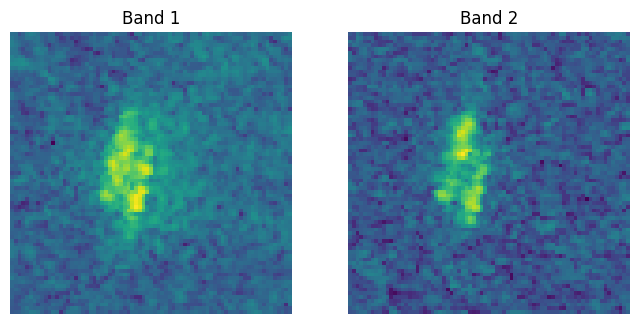

In [6]:
import numpy as np
import matplotlib.pyplot as plt

band_1_data = train['band_1'].iloc[12]
band_2_data = train['band_2'].iloc[12]

band_1_array = np.array(band_1_data).reshape(75, 75)
band_2_array = np.array(band_2_data).reshape(75, 75)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(band_1_array)
plt.title('Band 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(band_2_array)
plt.title('Band 2')
plt.axis('off')

plt.show()

In [7]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [8]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)


plotmy3d(X_band_1[12,:,:], 'iceberg')

In [9]:
plotmy3d(X_band_1[14,:,:], 'Ship')

code: https://www.kaggle.com/code/devm2024/keras-model-for-beginners-0-210-on-lb-eda-r-d

### Preprocessing

#### Variables

In [10]:
target_train = train['is_iceberg']

train['inc_angle'] = pd.to_numeric(train['inc_angle'], errors='coerce')
test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors='coerce')    # errors='coerce': 오류는 NaN 처리
train['inc_angle'] = train['inc_angle'].fillna(method='pad')    # 결측치를 이전값으로 채워넣기
test['inc_angle']=test['inc_angle'].fillna(method='pad')

X_angle = train['inc_angle']
X_test_angle=test['inc_angle']

In [11]:
X_angle.shape

(1604,)

In [12]:
pd.to_numeric(test['inc_angle'])

0       34.966400
1       32.615072
2       37.505433
3       34.473900
4       43.918874
          ...    
8419    34.795500
8420    32.246683
8421    39.503200
8422    33.638000
8423    36.758181
Name: inc_angle, Length: 8424, dtype: float64

In [13]:
test['inc_angle']

0       34.966400
1       32.615072
2       37.505433
3       34.473900
4       43.918874
          ...    
8419    34.795500
8420    32.246683
8421    39.503200
8422    33.638000
8423    36.758181
Name: inc_angle, Length: 8424, dtype: float64

In [14]:
# generate training data
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train['band_1']])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train['band_2']])
X_band_3 = (X_band_1+X_band_2)/2

X_train = np.concatenate([X_band_1[:, :, :, np.newaxis],       # np.newaxis: 새로운 axis를 추가
                          X_band_2[:, :, :, np.newaxis],
                          X_band_3[:, :, :, np.newaxis]], axis=-1)

X_band_test_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in test['band_1']])
X_band_test_2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in test['band_2']])
X_band_test_3 = (X_band_test_1+X_band_test_2)/2

X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis],       # np.newaxis: 새로운 axis를 추가
                          X_band_test_2[:, :, :, np.newaxis],
                          X_band_test_3[:, :, :, np.newaxis]], axis=-1)

#### Version error

In [15]:
#pip show tensorflow

In [16]:
#pip show keras

In [17]:
#pip install --upgrade tensorflow

In [18]:
# pip install --upgrade keras

#### Data augmentation

In [19]:
from matplotlib import pyplot
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator   # keras와 tensorflow가 호환되지 않으면 오류뜸.. 업데이트 해주기!
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization    # 버전 문제로 삭제된 패키지 있음..
from keras.layers import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras.layers import LeakyReLU, PReLU
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [20]:
from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [21]:
# Generator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size=64

gen = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         width_shift_range=0,
                         height_shift_range=0,
                         channel_shift_range=0,
                         zoom_range=0.2,
                         rotation_range=10)

In [22]:
# Two generators for two inputs
def gen_flow_for_two_inputs(X1, X2, y):
  genX1= gen.flow(X1, y, batch_size=batch_size, seed=55)
  genX2= gen.flow(X2.values.reshape(-1,1,1,1), y, batch_size=batch_size, seed=55)
  while True:
    X1i = genX1.next()
    X2i = genX2.next()
    yield [X1i[0], X2i[1]], X1i[1]    # 데이터 증강

def get_callbacks(filepath, patience=2):
  es = EarlyStopping('val_loss', patience=10, mode='min')   # early stopping
  msave = ModelCheckpoint(filepath, save_best_only=True)   # 최적의 가중치 저장
  return [es, msave]

### Modeling

In [23]:
# Build Model
def getVggAngleModel():
  input_2 = Input(shape=[1], name='angle')   # shape이 [1]인 angle 이름의 레이어로 인풋 받기
  angle_layer = Dense(1, )(input_2)       # input_2를 처리하는 레이어
  base_model = VGG16(weights='imagenet', include_top=False,     # Transfer Learning의 VGG16 사용, ImageNet데이터셋에서 사전훈련된 가중치 사용
                     input_shape=X_train.shape[1:], classes=1)
  x = base_model.get_layer('block5_pool').output    # VGG16모델에서 block5_pool 레이어의 출력을 x에 할당

  x = GlobalMaxPooling2D()(x)
  merge_one = concatenate([x, angle_layer])   # merge
  merge_one = Dense(512, activation='relu', name='fc2')(merge_one)   # 512개의 유닛을 가진 dense layer 추가
  merge_one = Dropout(0.3)(merge_one)    # 드롭아웃
  merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
  merge_one = Dropout(0.3)(merge_one)

  predictions = Dense(1, activation='sigmoid')(merge_one)

  model = Model(inputs=[base_model.input, input_2], outputs=predictions)
  sgd = SGD(learning_rate=1e-3, momentum=0.9)
  model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

  return model

In [24]:
# k-fold cross validation
def myAngleCV(X_train, X_angle, X_test):
  K=3
  folds=list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))

  y_test_pred_log=0
  y_train_pred_log=0
  y_valid_pred_log=0.0*target_train

  for j, (train_idx, test_idx) in enumerate(folds):
    print('\n=======================FOLD=', j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout = target_train[test_idx]

    X_angle_cv = X_angle[train_idx]
    X_angle_hold = X_angle[test_idx]

    file_path = "%s_aug_model_weights.keras"%j
    callbacks=get_callbacks(filepath=file_path, patience=5)
    gen_flow=gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel = getVggAngleModel()
    galaxyModel.fit(
        gen_flow,
        steps_per_epoch=24,
        epochs=100,
        shuffle=True,
        verbose=1,
        validation_data=([X_holdout, X_angle_hold], Y_holdout),
        callbacks=callbacks)

    # best model
    galaxyModel.load_weights(filepath=file_path)
    score = galaxyModel.evaluate([X_train_cv, X_angle_cv], y_train_cv, verbose=0)
    print('Train loss: ', score[0])
    print('Train accuracy: ', score[1])
    score = galaxyModel.evaluate([X_holdout, X_angle_hold], Y_holdout, verbose=0)
    print('Test loss: ', score[0])
    print('Test accuracy: ', score[1])

    # Get scores
    pred_valid = galaxyModel.predict([X_holdout, X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    temp_test = galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log += temp_test.reshape(temp_test.shape[0])

    temp_train = galaxyModel.predict([X_train, X_angle])
    y_train_pred_log += temp_train.reshape(temp_train.shape[0])

  y_test_pred_log = y_test_pred_log/K
  y_train_pred_log = y_train_pred_log/K

  print('\n Train Log Loss Validation= ', log_loss(target_train, y_train_pred_log))
  print(' Test Log Loss Validation= ', log_loss(target_train, y_valid_pred_log))

  return y_test_pred_log


In [25]:
preds=myAngleCV(X_train, X_angle, X_test)


=======================FOLD= 0
58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/100
24/24 [==============================] - 24s 492ms/step - loss: 0.6460 - accuracy: 0.6309 - val_loss: 0.4711 - val_accuracy: 0.7383
Epoch 2/100
24/24 [==============================] - 4s 150ms/step - loss: 0.4406 - accuracy: 0.7726 - val_loss: 0.6280 - val_accuracy: 0.7215
Epoch 3/100
24/24 [==============================] - 6s 269ms/step - loss: 0.3376 - accuracy: 0.8304 - val_loss: 0.4684 - val_accuracy: 0.7421
Epoch 4/100
24/24 [==============================] - 3s 145ms/step - loss: 0.2695 - accuracy: 0.8800 - val_loss: 0.5838 - val_accuracy: 0.7383
Epoch 5/100
24/24 [==============================] - 4s 166ms/step - loss: 0.2399 - accuracy: 0.8925 - val_loss: 0.5101 - val_accuracy: 0.7701
Epoch 6/100
24/24 [==============================] - 5s 204ms/step - loss: 0.2451 - accuracy: 0.8952 - val_loss: 0.8629 - val_accuracy: 0.7178
Epoch 7/100
24/24 [=========================